In [ ]:
import numpy as np
from spec_id import Get_repeats, Scale_model
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d, interp2d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [ ]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_mar22.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

IDc=[]  # compact sample
IDd=[]  # diffuse sample

IDmL=[]  # low mass sample
IDmH=[]  # high mass sample

for i in range(len(ids)):
    if 0.11 < comp[i]:
        IDd.append(i)
    if 0.11 > comp[i]:
        IDc.append(i)
    if 10.931 > lmass[i]:
        IDmL.append(i)
    if 10.931 < lmass[i]:
        IDmH.append(i)

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [ ]:
def Get_entry_size(param):
    plist = np.unique(param)
    size=np.zeros(len(plist))
    for i in range(len(plist)):
        size[i]=len(param[param == plist[i]])
    return plist,size

def Get_merr_1sig(uni,size):
    psum=[]
    for i in range(len(size)):
        psum.append(size[i])
        if sum(psum) >= 160:
            break
        
    psum2=[]
    for i in range(len(size)):
        psum2.append(size[::-1][i])
        if sum(psum2) >= 160:
            break
    return uni[len(psum)-1],uni[-(len(psum2)-1)]

def Plot_mc(file_name,m_param,a_param,save_plot=False,fname_adj=''):
    merr,aerr=Readfile(file_name)
    s = Get_repeats(merr, aerr)
    muni, msize = Get_entry_size(merr)
    auni, asize = Get_entry_size(aerr)
    lm,hm = Get_merr_1sig(muni,msize)
    la,ha = Get_merr_1sig(auni,asize)

    gs=gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,4])

    plt.figure(figsize=[8,8])
    gs.update(wspace=0.0,hspace=0.0)
    ax=plt.subplot(gs[1,0])
    plt.scatter(merr, aerr, s=s,label='MC points')
    plt.plot(m_param,a_param, 'rd',label='Model')
    # plt.plot(muni[np.argmax(msize)],auni[np.argmax(asize)],'p',color='#f6a300',label='Mode')
    plt.axvline(lm,color='k',linestyle='--',alpha=.5,label='1 $\sigma$')
    plt.axvline(hm,color='k',linestyle='--',alpha=.5)
    plt.axhline(la,color='k',linestyle='--',alpha=.5)
    plt.axhline(ha,color='k',linestyle='--',alpha=.5)
    plt.ylim(0,6)
    plt.xlim(0,0.03)
    plt.xticks([0.00475,0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475,0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))
    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xlabel('Z/Z$_\odot$',size=20)
    plt.ylabel('Average Age (Gyrs)',size=20)
    # plt.legend(loc=4,fontsize=15)


    plt.subplot(gs[1,1])
    plt.hist(aerr,30,orientation='horizontal')
    plt.axhline(la,color='k',linestyle='--',alpha=.5)
    plt.axhline(ha,color='k',linestyle='--',alpha=.5)
    plt.ylim(0,6)
    plt.yticks([])
    plt.xticks([])

    plt.subplot(gs[0,0])
    plt.hist(merr,25)
    plt.axvline(lm,color='k',linestyle='--',alpha=.5)
    plt.axvline(hm,color='k',linestyle='--',alpha=.5)
    plt.xlim(0,.03)
    plt.yticks([])
    plt.xticks([])
    plt.gcf().subplots_adjust(bottom=0.165,left=0.12)
    
    if save_plot == False:
        plt.show()
        plt.close()
        
    else:
        plt.savefig('../important_plots/%s_mcerr_mar23.png' % fname_adj)
        plt.close()

In [ ]:
def Single_gal_fit_MCerr_bestfit_normwmean_cont_feat(spec, tau, metal, A, sim_m, sim_a, sim_t, specz, gal_id,
                                                name, repeats=100,tau_scale='tau_scale_ntau.dat'):

    mlist = []
    alist = []

    wv, flux, err = np.load(spec)
    wv,flux,err=np.array([wv[wv<11100],flux[wv<11100],err[wv<11100]])
    mwv, mfl = np.load('../../../fsps_models_for_fit/galaxy_models/m%s_a%s_t%s_z%s_%s_model.npy'
                       % (sim_m,sim_a,sim_t,specz,gal_id))

    imfl = interp1d(mwv, mfl)(wv)
    C = Scale_model(flux, err, imfl)

    FL=imfl*C
    wv/=(1+specz)

    ###############Get indicies
    IDf = []
    IDc = []
    for i in range(len(wv)):
        if 3800 <= wv[i] <= 3850 or 3910 <= wv[i] <= 4030 or 4080 <= wv[i] <= 4125 or 4250 <= wv[i] <= 4385 or 4515 \
                <= wv[i] <= 4570 or 4810 <= wv[i] <= 4910 or 4975 <= wv[i] <= 5055 or 5110 <= wv[i] <= 5285:
            IDf.append(i)
        if wv[0] <= wv[i] <= 3800 or 3850 <= wv[i] <= 3910 or 4030 <= wv[i] <= 4080 or 4125 <= wv[i] <= 4250 or 4385 \
                <= wv[i] <= 4515 or 4570 <= wv[i] <= 4810 or 4910 <= wv[i] <= 4975 or 5055 <= wv[i] <= 5110:
            IDc.append(i)

    ###############Get model list

    fmf=[]
    cmf = []
    for i in range(len(metal)):
        for ii in range(len(A)):
            for iii in range(len(tau)):
                W,MF = np.load('../../../fsps_models_for_fit/galaxy_models/m%s_a%s_t%s_z%s_%s_model.npy'
                       % (metal[i],A[ii],tau[iii],specz,gal_id))
                iMF = interp1d(W/(1+specz), MF)(wv)
                Cm = Scale_model(FL, err, iMF)
                fmf.append(Cm*iMF[IDf])
                cmf.append(Cm*iMF[IDc])

    fmf=np.array(fmf)
    cmf = np.array(cmf)

    ultau = np.append(0, np.power(10, np.array(tau[1:]) - 9))

    scale = Readfile(tau_scale)
    overhead = []
    for i in range(len(scale)):
        amt = []
        for ii in range(len(A)):
            if A[ii] > scale[i][-1]:
                amt.append(1)
        overhead.append(sum(amt))

    for xx in range(repeats):
        fl = FL + np.random.normal(0, err)

        Fchi = np.sum(((fl[IDf] - fmf) / err[IDf]) ** 2, axis=1).reshape([len(metal), len(A), len(tau)]).astype(np.float128).T
        Cchi = np.sum(((fl[IDc] - cmf) / err[IDc]) ** 2, axis=1).reshape([len(metal), len(A), len(tau)]).astype(np.float128).T

        newCchi = np.zeros(Cchi.shape)
        newFchi = np.zeros(Fchi.shape)

        for i in range(len(Cchi)):
            if i == 0:
                newCchi[i] = Cchi[i]
                newFchi[i] = Fchi[i]
            else:
                cframe = interp2d(metal, scale[i], Cchi[i])(metal, A[:-overhead[i]])
                newCchi[i] = np.append(cframe, np.repeat([np.repeat(1E8, len(metal))], overhead[i], axis=0), axis=0)

                fframe = interp2d(metal, scale[i], Fchi[i])(metal, A[:-overhead[i]])
                newFchi[i] = np.append(fframe, np.repeat([np.repeat(1E8, len(metal))], overhead[i], axis=0), axis=0)

        ####### Create normalize probablity marginalized over tau
        cprob = np.exp(-newCchi.T.astype(np.float128) / 2)

        Pc = np.trapz(cprob, ultau, axis=2)
        Cc = np.trapz(np.trapz(Pc, A, axis=1), metal)

        Cprob = cprob / Cc

        fprob = np.exp(-newFchi.T.astype(np.float128) / 2)

        Pf = np.trapz(fprob, ultau, axis=2)
        Cf = np.trapz(np.trapz(Pf, A, axis=1), metal)

        Fprob = fprob / Cf

        prob = Cprob*(Fprob**5)

        P0 = np.trapz(prob, ultau, axis=2).T
        C0 = np.trapz(np.trapz(P0, metal, axis=1), A)
        prob = P0/C0

        idmax = np.argwhere(prob == np.max(prob))

        for i in range(len(idmax)):
            alist.append(A[idmax[i][0]])
            mlist.append(metal[idmax[i][1]])

        if repeats <= len(alist):
            break

    fn ='mcerr/' + name + '.dat'
    dat = Table([mlist, alist], names=['metallicities', 'age'])
    ascii.write(dat, fn)

    return

In [27]:
Single_gal_fit_MCerr_bestfit_normwmean_cont_feat('spec_stacks_jan24/s40597_stack.npy',tau,metal,age,0.019,2.3,0,1.221,
                                                 's40597','s40597_mcerr2',repeats=100)
print 'done'

done


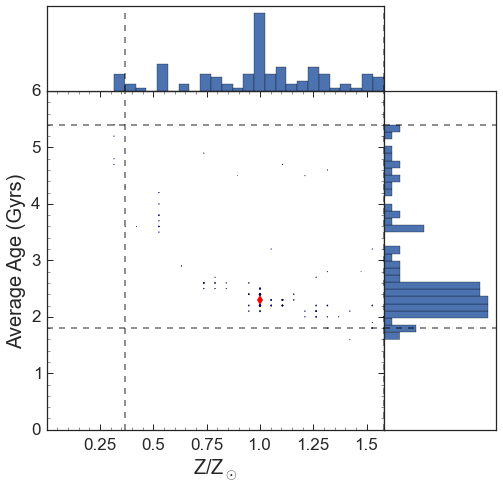

In [28]:
%matplotlib inline

Plot_mc('mcerr/s40597_mcerr2.dat',0.019,2.3)

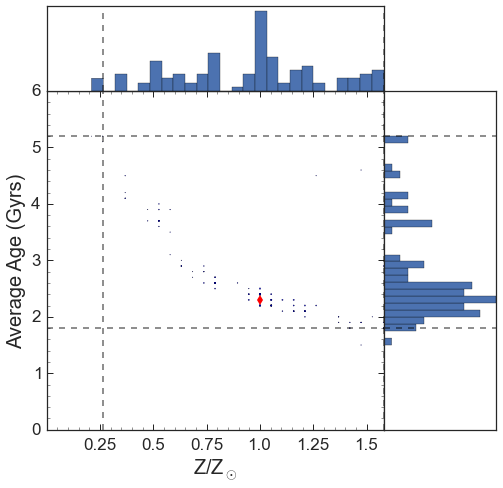

In [24]:
%matplotlib inline

Plot_mc('mcerr/s40597_mcerr.dat',0.019,2.3)

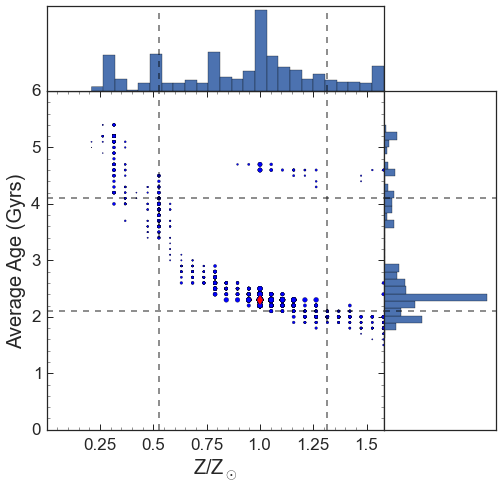

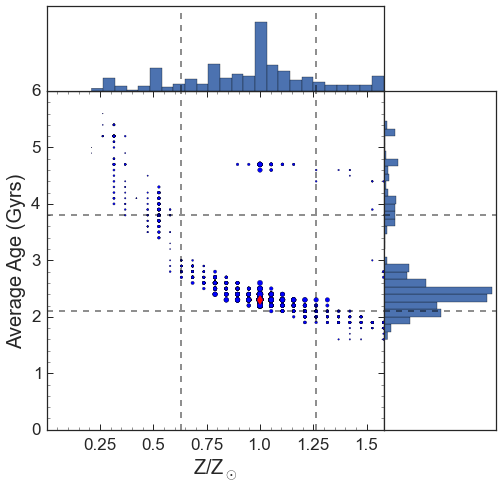

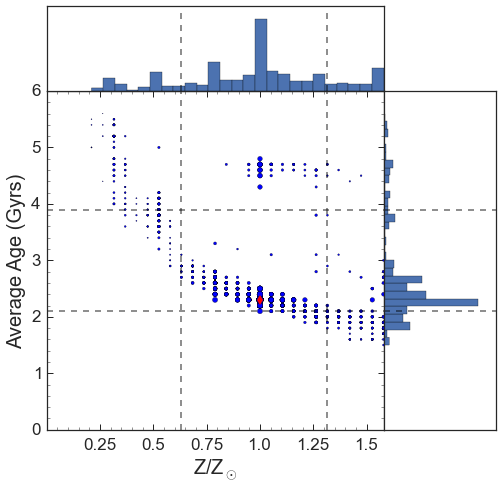

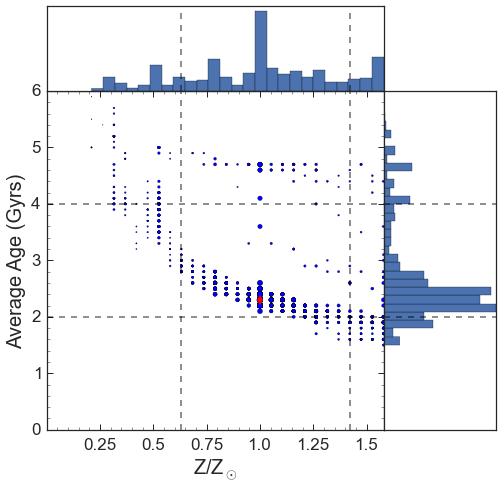

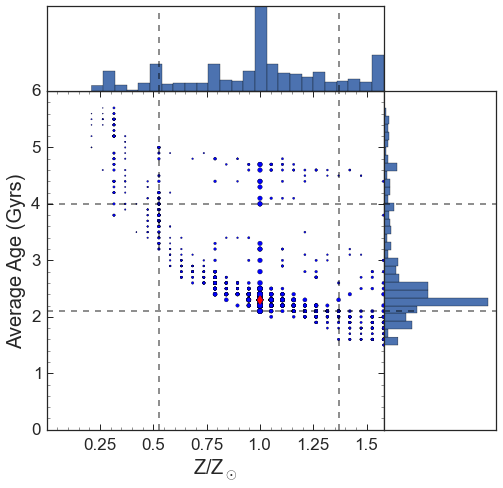

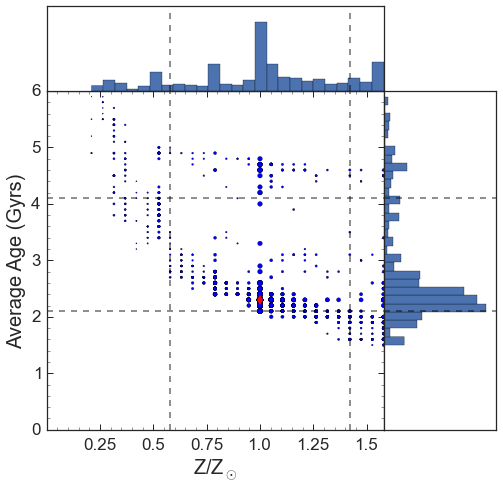

In [30]:
Plot_mc('mcerr/s40597_mcerr0.5.dat',0.019,2.3)
Plot_mc('mcerr/s40597_mcerr1.dat',0.019,2.3)
Plot_mc('mcerr/s40597_mcerr2.dat',0.019,2.3)
Plot_mc('mcerr/s40597_mcerr3.dat',0.019,2.3)
Plot_mc('mcerr/s40597_mcerr4.dat',0.019,2.3)
Plot_mc('mcerr/s40597_mcerr5.dat',0.019,2.3)

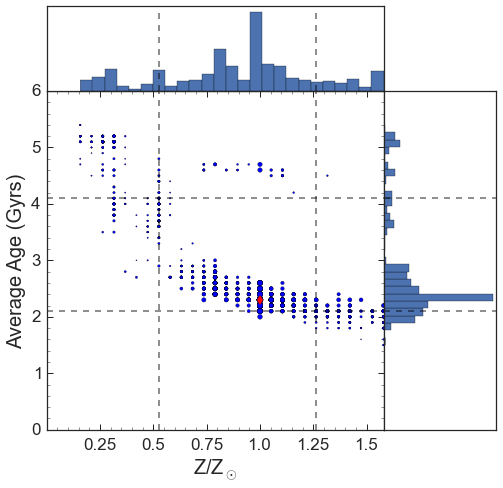

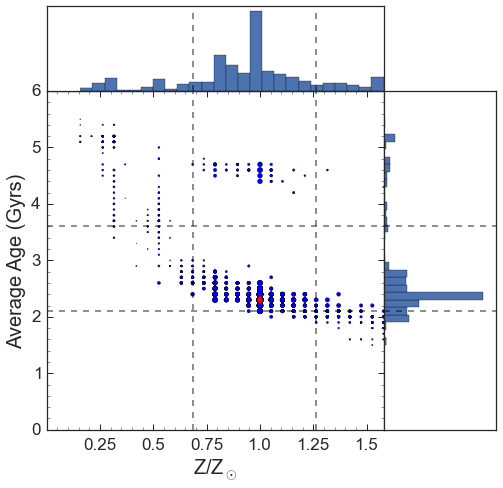

In [31]:
Plot_mc('mcerr/s39170_mcerr0.5.dat',0.019,2.3)
Plot_mc('mcerr/s39170_mcerr1.dat',0.019,2.3)
# Plot_mc('mcerr/s40597_mcerr2.dat',0.019,2.3)
# Plot_mc('mcerr/s40597_mcerr3.dat',0.019,2.3)
# Plot_mc('mcerr/s40597_mcerr4.dat',0.019,2.3)
# Plot_mc('mcerr/s40597_mcerr5.dat',0.019,2.3)

In [ ]:
%matplotlib inline


mp = [0.005,0.012,0.019,0.024]
ap = [1.5,3.0,4.5]

for i in range(len(ap)):
    for ii in range(len(mp)):
        Plot_mc('mcerr/com_mcerr_mar23_%s_%s.dat' % (mp[ii],ap[i]) ,mp[ii],ap[i], save_plot=True, fname_adj='com_%s_%s' % (mp[ii],ap[i]))